# Telecom Customer Churn

In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import skew, kurtosis

import mlflow
import os
from pathlib import Path
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [81]:
ROOT_PATH = Path(__name__).resolve().parent.parent

FILE_NAME = "TelecomCustomerChurn.csv"

FILE_PATH = os.path.join(ROOT_PATH, "data",FILE_NAME)

In [82]:
df = pd.read_csv(FILE_PATH)
df.head()

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Monthly,Yes,Manual,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Manual,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Monthly,Yes,Manual,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Monthly,Yes,Manual,70.70,151.65,Yes


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   Tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [84]:
df.isnull().sum()

customerID          0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [85]:
df["TotalCharges"] = df["TotalCharges"].apply(
    lambda x: None if x == " " else float(x)
)

In [86]:
df.isnull().sum()

customerID           0
Gender               0
SeniorCitizen        0
Partner              0
Dependents           0
Tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [87]:
amount_of_nulls = df["TotalCharges"].isna().sum()
amount_of_data = len(df)

print(f"{(amount_of_nulls / amount_of_data) * 100} %")

0.1561834445548772 %


Since this amount of NaN values represents only 0.15% of the data, we can take it out because it won't make a big impact on our analysis

In [88]:
df = df.loc[~df["TotalCharges"].isna()]

In [89]:
df

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Monthly,Yes,Manual,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Manual,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Monthly,Yes,Manual,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Monthly,Yes,Manual,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Manual,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No,DSL,Yes,...,No,No,No,No,Monthly,Yes,Manual,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Monthly,Yes,Manual,74.40,306.60,Yes


#### Evaluating the Gender acitivity

In [90]:
df_gender_churn = df.groupby(
    ["Gender", "Churn"]
    ).agg({"Churn":"count"}).rename(
        columns={"Churn": "churn_count"}
    ).reset_index()

df_gender_churn = df_gender_churn.pivot_table(
    index="Gender", values="churn_count", columns="Churn"
)

df_gender_churn

Churn,No,Yes
Gender,,
Female,2544.0,939.0
Male,2619.0,930.0


Just evalue if there is a statistical relevance on Male and Female churns

Applying a Statistical teste called: Chi-Squared 

In [91]:
def statistical_chisquared(p_value: float):
    if p_value <= 0.05:
        print(f"There is a relevant difference between these genres. \np_value: {p_value}")
    else:
        print(f"There is no relevant difference between these genres. \np_value: {p_value}")

In [92]:
chi2, p, dof, expected = chi2_contingency(df_gender_churn)
statistical_chisquared(p)

There is no relevant difference between these genres. 
p_value: 0.490488470706551


In [93]:
df["Gender"].value_counts()

Gender
Male      3549
Female    3483
Name: count, dtype: int64

In [94]:
df.groupby(
    ["Gender"]
    ).agg({"TotalCharges":"sum"}).rename(
        columns={"TotalCharges": "TotalCharges_sum"}
    ).reset_index()

,Gender,TotalCharges_sum
0,Female,7952354.2
1,Male,8103814.5


#### Evaluating type of service

In [95]:
df["InternetService"].value_counts()

InternetService
Fiber optic    3096
DSL            2416
No             1520
Name: count, dtype: int64

In [96]:
df_internet_service = df.groupby(
    ["InternetService", "Churn"]
    ).agg({"Churn":"count"}).rename(
        columns={"Churn": "churn_count"}
    ).reset_index()

df_internet_service = df_internet_service.pivot_table(
    index="InternetService", values="churn_count", columns="Churn"
)

df_internet_service["total"] = df_internet_service["No"] + df_internet_service["Yes"]

df_internet_service["churn_percent_service_categ"] = (df_internet_service["Yes"] / df_internet_service["total"]) * 100
df_internet_service["churn_percent_global"] = (df_internet_service["total"] / df_internet_service["total"].sum()) * 100

df_internet_service

Churn,No,Yes,total,churn_percent_service_categ,churn_percent_global
InternetService,,,,,
DSL,1957.0,459.0,2416.0,18.998344,34.357224
Fiber optic,1799.0,1297.0,3096.0,41.892765,44.027304
No,1407.0,113.0,1520.0,7.434211,21.615472


The Fiber Optic Internet represents 44% of the customer. However it is clear that the amount of customer in Fiber Optic 41% are cancelling our sevices. Proportionally it makes sense because the are the biggest amount of customers, although our services are not supplying the customer expecations of more than 40% of our client databases.

Based on bussiness areas needs I could proceed with the some more Ad Hoc Analysis. Although I'll move forward to the modeling structure

In [97]:
df

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Monthly,Yes,Manual,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Manual,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Monthly,Yes,Manual,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Monthly,Yes,Manual,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Manual,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No,DSL,Yes,...,No,No,No,No,Monthly,Yes,Manual,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Monthly,Yes,Manual,74.40,306.60,Yes


In [98]:
df_dummy = pd.get_dummies(data=df.drop(["customerID", "Churn"], axis=1), dtype=int)
df_dummy.head()

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges,Gender_Female,Gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_No,StreamingMovies_Yes,Contract_Monthly,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Manual
0,0,1,29.85,29.85,1,0,0,1,1,0,...,1,0,1,0,0,0,1,0,0,1
1,0,34,56.95,1889.50,0,1,1,0,1,0,...,1,0,0,1,0,1,0,0,0,1
2,0,2,53.85,108.15,0,1,1,0,1,0,...,1,0,1,0,0,0,1,0,0,1
3,0,45,42.30,1840.75,0,1,1,0,1,0,...,1,0,0,1,0,1,0,1,0,0
4,0,2,70.70,151.65,1,0,1,0,1,0,...,1,0,1,0,0,0,1,0,0,1


In [99]:
df_dummy.describe()

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges,Gender_Female,Gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_No,StreamingMovies_Yes,Contract_Monthly,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Manual
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441,0.495307,0.504693,0.517491,0.482509,0.701507,0.298493,...,0.611633,0.388367,0.551052,0.209329,0.239619,0.407281,0.592719,0.219283,0.216297,0.564420
std,0.368844,24.545260,30.085974,2266.771362,0.500014,0.500014,0.499729,0.499729,0.457629,0.457629,...,0.487414,0.487414,0.497422,0.406858,0.426881,0.491363,0.491363,0.413790,0.411748,0.495868
min,0.000000,1.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,35.587500,401.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.000000,55.000000,89.862500,3794.737500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


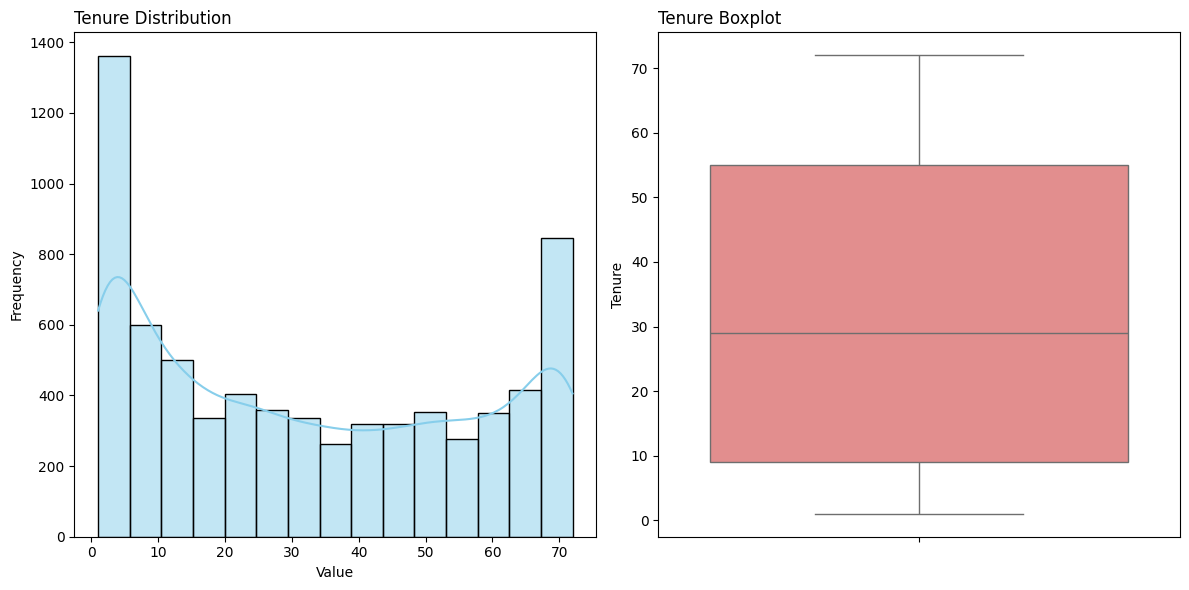

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=df_dummy, x="Tenure", kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Tenure Distribution", loc="left")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")

sns.boxplot(data=df_dummy, y="Tenure", ax=axes[1], color="lightcoral")
axes[1].set_title("Tenure Boxplot", loc="left")

plt.tight_layout()
plt.show();

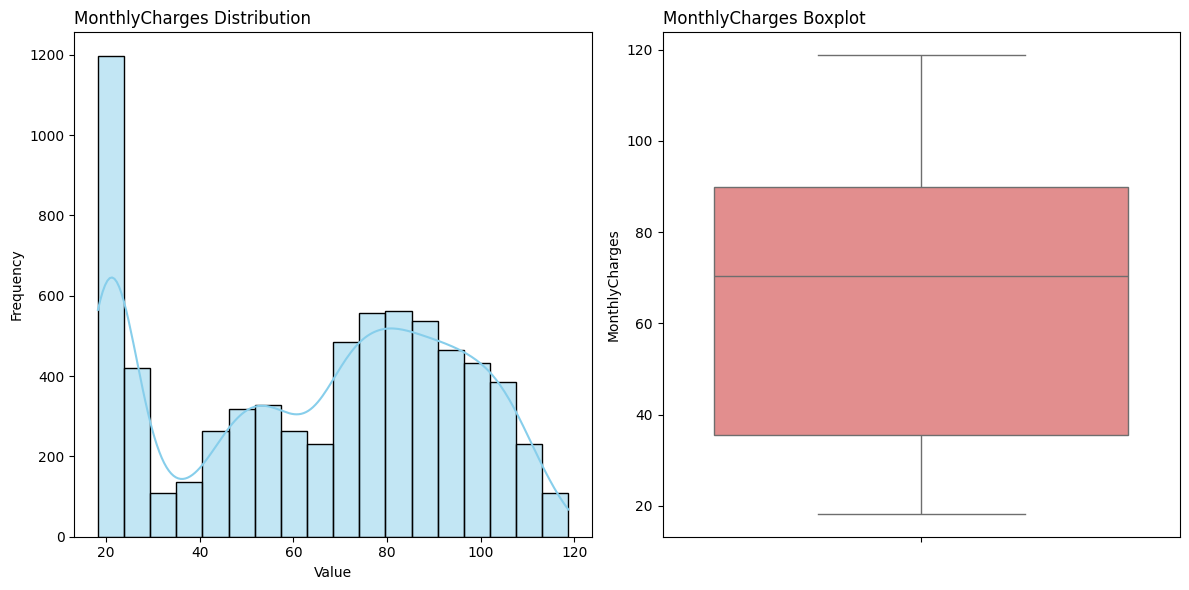

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=df_dummy, x="MonthlyCharges", kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("MonthlyCharges Distribution", loc="left")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")

sns.boxplot(data=df_dummy, y="MonthlyCharges", ax=axes[1], color="lightcoral")
axes[1].set_title("MonthlyCharges Boxplot", loc="left")

plt.tight_layout()
plt.show();

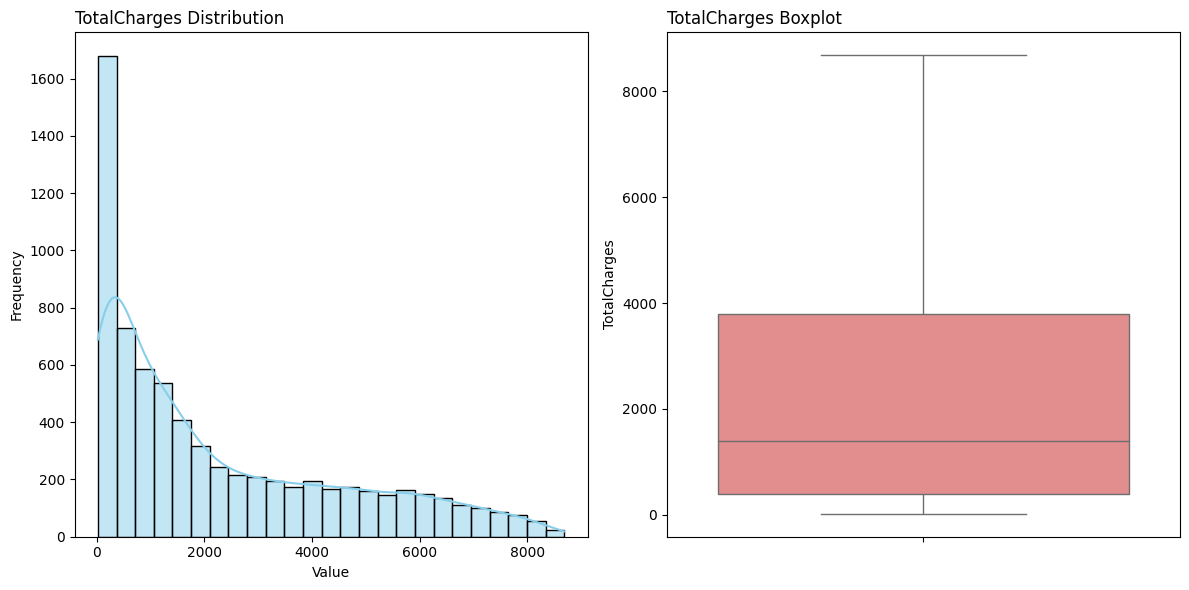

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=df_dummy, x="TotalCharges", kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("TotalCharges Distribution", loc="left")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")

sns.boxplot(data=df_dummy, y="TotalCharges", ax=axes[1], color="lightcoral")
axes[1].set_title("TotalCharges Boxplot", loc="left")

plt.tight_layout()
plt.show();

In [103]:
df_dummy_temp = pd.get_dummies(data=df.drop(["customerID", "Churn"], axis=1), dtype=int, drop_first=True)

vif_data = pd.DataFrame()
vif_data["Feature"] = df_dummy_temp.columns
vif_data["VIF"] = [variance_inflation_factor(df_dummy_temp.values, i) for i in range(df_dummy_temp.shape[1])]

vif_data

,Feature,VIF
0,SeniorCitizen,1.372809
1,Tenure,19.961285
2,MonthlyCharges,211.407548
3,TotalCharges,20.975890
4,Gender_Male,2.021273
5,Partner_Yes,2.822596
6,Dependents_Yes,1.967383
7,PhoneService_Yes,47.183952
8,MultipleLines_Yes,2.843424
9,InternetService_Fiber optic,17.342421


Variables with high level of multicolinearity. I'll try dropping some variables with high values to evaluate if the VIF reduces

In [104]:
test_cols_drop = ["customerID", "Churn", "MonthlyCharges", "Tenure"]
df_dummy_temp = pd.get_dummies(data=df.drop(test_cols_drop, axis=1), dtype=int, drop_first=True)

vif_data = pd.DataFrame()
vif_data["Feature"] = df_dummy_temp.columns
vif_data["VIF"] = [variance_inflation_factor(df_dummy_temp.values, i) for i in range(df_dummy_temp.shape[1])]

vif_data

,Feature,VIF
0,SeniorCitizen,1.352379
1,TotalCharges,7.948890
2,Gender_Male,1.923930
3,Partner_Yes,2.747944
4,Dependents_Yes,1.959154
5,PhoneService_Yes,9.229601
6,MultipleLines_Yes,2.504991
7,InternetService_Fiber optic,3.858821
8,InternetService_No,3.173177
9,OnlineSecurity_Yes,1.980164


There was a good reduction of VIF on the remaining variables. Let's proceed with these to the model

Checking data Balancing

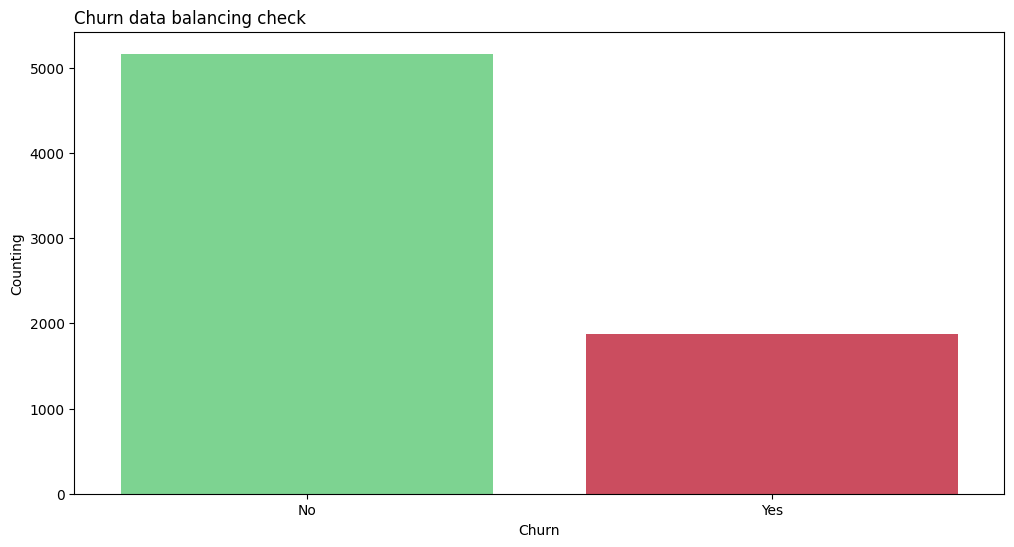

In [145]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="Churn", hue="Churn", palette={"Yes": "#E03850", "No": "#6FE189"})
plt.title("Churn data balancing check", loc="left")
plt.ylabel("Counting")
plt.show();

In [155]:
balance_analysis = pd.DataFrame(
    [df["Churn"].value_counts().to_dict()]
).T.rename(columns={0: "count"})

balance_analysis["percent"] = (balance_analysis["count"] / balance_analysis["count"].sum()) * 100
balance_analysis

,count,percent
No,5163,73.421502
Yes,1869,26.578498


Separate data into X, y, Train and Test

In [105]:
X = df_dummy.copy()
y = df.loc[:, ["Churn"]]

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Independent DF for Training:", X_train.shape)
print("Independent DF for Testing:", X_test.shape)
print("\nDependent DF for Training:", y_train.shape)
print("Dependent DF for Testing:", y_test.shape)

Independent DF for Training: (5625, 37)
Independent DF for Testing: (1407, 37)

Dependent DF for Training: (5625, 1)
Dependent DF for Testing: (1407, 1)


In [125]:
def compute_statistics(series: pd.Series):
    data = np.array(series).astype(float)
    
    stats = {
        "mean": np.mean(data),
        "median": np.median(data),
        "std": np.std(data, ddof=1),
        "skewness": skew(data, bias=False),
        "kurtosis": kurtosis(data, bias=False)
    }

    return stats

In [133]:
def get_variable_dist(df: pd.DataFrame):
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment("Data Drift Monitor")

    for col in df.columns:
        with mlflow.start_run(run_name=f"drift_{datetime.today()}"):
            ## Creating IMAGE
            img_path = f"../data/image/{col}.png"

            _, axes = plt.subplots(1, 2, figsize=(12, 6))
            sns.histplot(data=df, x=f"{col}", kde=True, ax=axes[0], color="skyblue")
            axes[0].set_title(f"{col} Distribution", loc="left")
            axes[0].set_xlabel("Value")
            axes[0].set_ylabel("Frequency")

            sns.boxplot(data=df, y=f"{col}", ax=axes[1], color="lightcoral")
            axes[1].set_title(f"{col} Boxplot", loc="left")

            plt.savefig(img_path)
            plt.close()

            ## Creating Statistics
            stats = compute_statistics(df[col])

            mlflow.set_tag(key="table_column", value=col)
            mlflow.log_artifact(img_path, artifact_path=f"plots")
            mlflow.log_metric(key="mean", value=stats["mean"])
            mlflow.log_metric(key="median", value=stats["median"])
            mlflow.log_metric(key="std", value=stats["std"])
            mlflow.log_metric(key="skewness", value=stats["skewness"])
            mlflow.log_metric(key="kurtosis", value=stats["kurtosis"])

In [134]:
get_variable_dist(df_dummy)

🏃 View run drift_2025-10-20 00:06:05.665520 at: http://localhost:5000/#/experiments/272754639782713434/runs/f9a7e1f0c47a4beaa56729e3704c43fe
🧪 View experiment at: http://localhost:5000/#/experiments/272754639782713434
🏃 View run drift_2025-10-20 00:06:06.019286 at: http://localhost:5000/#/experiments/272754639782713434/runs/496288c82f844ec8b41abc079ec838aa
🧪 View experiment at: http://localhost:5000/#/experiments/272754639782713434
🏃 View run drift_2025-10-20 00:06:06.373430 at: http://localhost:5000/#/experiments/272754639782713434/runs/50cac50838fa49f5ba4bc1db5d0474d8
🧪 View experiment at: http://localhost:5000/#/experiments/272754639782713434
🏃 View run drift_2025-10-20 00:06:06.712005 at: http://localhost:5000/#/experiments/272754639782713434/runs/d59af40db15c428292a881a54bcd5bf7
🧪 View experiment at: http://localhost:5000/#/experiments/272754639782713434
🏃 View run drift_2025-10-20 00:06:07.076431 at: http://localhost:5000/#/experiments/272754639782713434/runs/1210800d46d8423d93de